In [85]:
%matplotlib inline

import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'

In [31]:
nrows = 10000
bin_num = 1 ## number of bins to separate data by start_time
tmp_train, tmp_test, bins, bin_names = bosch_functions.create_grouped_index_df(bin_num)

data loading takes  65.0  seconds.


In [32]:
## create the skipped row numbers
none_selected_window_num = ['0']
skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()

train_cat_cols  = pd.read_csv(join(data_path, train_cat_file), index_col=id_column_name, nrows=0)
train_date_cols = pd.read_csv(join(data_path, train_date_file), index_col=id_column_name, nrows=0)
train_num_cols  = pd.read_csv(join(data_path, train_num_file), index_col=id_column_name, nrows=0)

In [33]:
print len(skipped_test_row_num), len(skipped_train_row_num)

674503 673861


### R&D work

Independent work to build LR models on both numerical and date features. Those LR
models will be used as feature selection tools.

    1. use all the numerical/date data and only first 50,000 rows
    2. try to build a LR model and understand the features

In [34]:
## select all the numerical columns and try to use LR
start_time = time.time()
train_num  = pd.read_csv(join(data_path, train_num_file),    index_col='Id', skiprows=skipped_train_row_num, nrows=50000)
train_date = pd.read_csv(join(data_path, train_date_file),   index_col='Id', skiprows=skipped_train_row_num, nrows=50000)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 13.0 seconds


In [35]:
print train_date.max().max(), train_date.min().min()

1717.86 0.39


In [36]:
## remove columns that mostly just NaN
train_num.fillna(-1., inplace=True)
train_date.fillna(-1., inplace=True)

In [37]:
start_time = time.time()
train_num_corr = train_num.corr()
train_date_corr = train_date.corr()
print 'finish calculating correlation using {} seconds'.format(round(time.time() - start_time, 0))

finish calculating correlation using 261.0 seconds


In [38]:
print train_num_corr.shape, train_date_corr.shape

(969, 969) (1156, 1156)


In [26]:
#train_date_corr

In [39]:
start_index = 0
thres = 0.5
num_removed_cols = set()
dat_removed_cols = set()

for column in train_num_corr.columns:
    start_index += 1
    if column not in num_removed_cols:
        for index, value in enumerate(train_num_corr[column][start_index:]):
            if abs(value) > thres:
                num_removed_cols.add(train_num_corr.columns[(index + start_index)])
               
start_index = 0           
for column in train_date_corr.columns:
    start_index += 1
    if column not in dat_removed_cols:
        for index, value in enumerate(train_date_corr[column][start_index:]):
            if abs(value) > thres:
                dat_removed_cols.add(train_date_corr.columns[(index + start_index)])

In [40]:
print len(num_removed_cols), len(dat_removed_cols), train_num_corr.shape[1], train_date_corr.shape[1]

921 1108 969 1156


In [41]:
max_corr_fea = train_num_corr['Response'][:-1].argmax()
min_corr_fea = train_num_corr['Response'][:-1].argmin()

In [42]:
print train_num_corr['Response'][:-1].max(), max_corr_fea, '\n', train_num_corr['Response'][:-1].min(), min_corr_fea

0.0893626579396 L3_S32_F3850 
-0.0569501205985 L3_S33_F3869


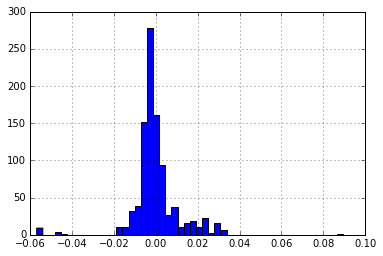

In [43]:
train_num_corr['Response'][:-1].hist(bins=50)

In [44]:
selected_num_col_names = [col for col in train_num.columns if col not in num_removed_cols]
selected_dat_col_names = [col for col in train_date.columns if col not in dat_removed_cols]

In [45]:
print len(selected_num_col_names), len(selected_dat_col_names)

48 48


In [46]:
selected_num_col_names.extend(['Id', 'Response'])
selected_dat_col_names.extend(['Id'])

load data using the selected columns.
train_num and train_cat data will be combined and used as a whole for the LR model training

In [47]:
start_time = time.time()
full_train_num  = pd.read_csv(join(data_path, train_num_file),    index_col='Id', skiprows=skipped_train_row_num, usecols=selected_num_col_names)
full_train_cat  = pd.read_csv(join(data_path, train_date_file),   index_col='Id', skiprows=skipped_train_row_num, usecols=selected_dat_col_names)
print 'finish loading full data using {} seconds'.format(round(time.time() - start_time, 0))

finish loading full data using 34.0 seconds


In [73]:
tmp_train_num = full_train_num.copy()
tmp_train_cat = full_train_cat.copy()

## remove columns that mostly just NaN
tmp_train_num.fillna(-1., inplace=True)
tmp_train_cat.fillna(-1., inplace=True)

print tmp_train_num.shape, tmp_train_cat.shape

(509886, 48) (509886, 48)


In [74]:
combined_train = pd.merge(tmp_train_num, tmp_train_cat, how='outer', left_index=True, right_index=True)

In [75]:
print combined_train.shape, dep_var_name in combined_train.columns
combined_train.head()

(509886, 96) True


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S39_D3966,L3_S42_D4029,L3_S42_D4033,L3_S42_D4037,L3_S42_D4041,L3_S42_D4045,L3_S42_D4049,L3_S42_D4053,L3_S42_D4057,L3_S46_D4135
Id,,,,,,,,,,,,,,,,,,,,,
6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
14,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
41,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [76]:
############## Section of regular validation #######################
train_index, valid_index = create_validation_index(combined_train, 0.3, dep_var_name, True)
valid_data = combined_train.ix[valid_index]
tmp_train  = combined_train.ix[train_index]

In [77]:
y = tmp_train[dep_var_name].values
X = tmp_train.drop(dep_var_name, axis=1)

valid_y = valid_data[dep_var_name].values
valid_X = valid_data.drop(dep_var_name, axis=1)

In [78]:
print X.shape, valid_X.shape

(356921, 95) (152965, 95)


In [79]:
C = 0.01

In [80]:
start_time = time.time()
LR_clf = LogisticRegression(C = C, class_weight='balanced', n_jobs = -1, penalty='l2')
LR_clf.fit(X, y)
print 'finish training LR model using {} seconds'.format(round(time.time() - start_time, 0))

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [81]:
pred = LR_clf.predict_proba(valid_X)[:, 1]

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

result from using constant fraction: 
mean of groud truth: 0.00641323178505
threshold for preds: 0.907512666314
0.079724974269

 

result from using flexsible threshold: (0.10051449974313409, 0.7422325440755092)


In [82]:
coef_l1_LR = LR_clf.coef_.ravel()

In [83]:
len(coef_l1_LR)

95

(array([  3.,   0.,   3.,   3.,   4.,  40.,   1.,   1.,  26.,   1.,   0.,
          0.,   0.,   1.,   2.,   1.,   2.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.4058657 , -0.35781755, -0.3097694 , -0.26172125, -0.2136731 ,
        -0.16562494, -0.11757679, -0.06952864, -0.02148049,  0.02656766,
         0.07461581,  0.12266396,  0.17071211,  0.21876026,  0.26680842,
         0.31485657,  0.36290472,  0.41095287,  0.45900102,  0.50704917,
         0.55509732,  0.60314547,  0.65119362,  0.69924178,  0.74728993,
         0.79533808,  0.84338623,  0.89143438,  0.93948253,  0.98753068,
         1.03557883,  1.08362698,  1.13167513,  1.17972329,  1.22777144,
         1.27581959,  1.32386774,  1.37191589,  1.41996404,  1.46801219,
         1.51606034,  1.56410849,  1.61215665,  1.6602048 ,  1.70825295,
 

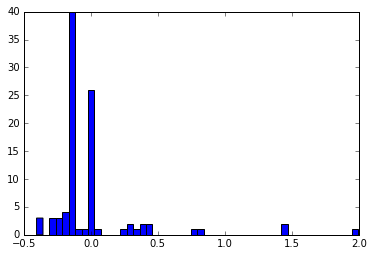

In [89]:
plt.hist(coef_l1_LR, bins=50)

(array([ 26.,   1.,   1.,   1.,   1.,  37.,   2.,   3.,   2.,   2.,   2.,
          4.,   0.,   1.,   1.,   2.,   3.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([  1.04347182e-04,   2.50598160e-02,   5.00152849e-02,
          7.49707537e-02,   9.99262225e-02,   1.24881691e-01,
          1.49837160e-01,   1.74792629e-01,   1.99748098e-01,
          2.24703567e-01,   2.49659036e-01,   2.74614504e-01,
          2.99569973e-01,   3.24525442e-01,   3.49480911e-01,
          3.74436380e-01,   3.99391849e-01,   4.24347317e-01,
          4.49302786e-01,   4.74258255e-01,   4.99213724e-01,
          5.24169193

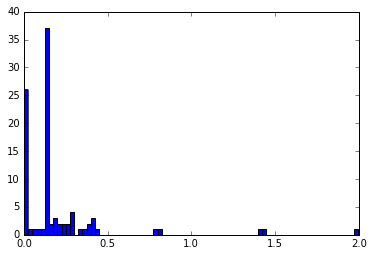

In [99]:
plt.hist(abs(coef_l1_LR), bins=80)

In [90]:
print np.argmax(coef_l1_LR), np.argmin(coef_l1_LR)

41 40


In [91]:
sorted_index = np.argsort(abs(coef_l1_LR))

In [104]:
coef_l1_LR[sorted_index][-19:]

array([ 0.25730656, -0.27214237,  0.27717454, -0.28075841,  0.28671067,
       -0.2958737 ,  0.33863482,  0.36509587, -0.3821762 ,  0.38715437,
       -0.40161981, -0.4058657 ,  0.41581182,  0.44451443,  0.77817978,
        0.80855061,  1.4200994 ,  1.44046263,  1.99654185])

In [94]:
## data used in model training
print X.shape

(356921, 95)


In [105]:
X.columns[sorted_index[-19:]]

Index([u'L3_S38_F3952', u'L0_S23_F619', u'L1_S25_F1855', u'L1_S25_F2799',
       u'L3_S29_F3379', u'L1_S24_F1808', u'L1_S24_F679', u'L1_S25_F2498',
       u'L1_S24_F1118', u'L3_S49_F4206', u'L0_S22_F546', u'L3_S31_F3834',
       u'L3_S29_F3464', u'L3_S50_F4243', u'L2_S28_F3222', u'L1_S25_F2231',
       u'L1_S24_F1581', u'L1_S24_F1672', u'L3_S32_F3850'],
      dtype='object')

In [100]:
X.columns[sorted_index]

Index([u'L0_S22_D543', u'L1_S24_D677', u'L3_S38_D3953', u'L3_S35_D3886',
       u'L1_S25_D2206', u'L1_S25_D1854', u'L2_S26_D3037', u'L1_S25_D2180',
       u'L1_S25_D2879', u'L3_S32_D3852', u'L1_S25_D2801', u'L2_S27_D3130',
       u'L2_S28_D3223', u'L1_S25_D2957', u'L1_S25_D2471', u'L1_S24_D1116',
       u'L1_S24_D1511', u'L1_S25_D2230', u'L0_S1_D26', u'L1_S25_D2754',
       u'L3_S39_D3966', u'L0_S12_D331', u'L3_S29_D3316', u'L1_S25_D2497',
       u'L3_S31_D3836', u'L1_S25_F2960', u'L3_S30_F3564', u'L1_S25_F2877',
       u'L1_S25_F2755', u'L0_S1_F24', u'L0_S0_D7', u'L0_S0_D13', u'L0_S0_D9',
       u'L0_S0_D11', u'L0_S0_D15', u'L0_S0_F0', u'L0_S0_D19', u'L0_S0_D21',
       u'L0_S0_D23', u'L1_S24_D1158', u'L0_S0_D5', u'L0_S0_D17', u'L0_S0_D3',
       u'L0_S0_D1', u'L3_S46_D4135', u'L0_S0_F20', u'L0_S0_F18', u'L0_S0_F16',
       u'L0_S0_F14', u'L0_S0_F12', u'L0_S0_F10', u'L0_S0_F8', u'L0_S0_F6',
       u'L0_S0_F22', u'L0_S0_F4', u'L0_S0_F2', u'L3_S42_D4045',
       u'L3_S42_D4057', u'L3_S4

In [86]:
print tmp_train_num.columns[np.argmax(coef_l1_LR)], tmp_train_num.columns[np.argmin(coef_l1_LR)]

L3_S32_F3850 L0_S8_F144


In [101]:
tmp_train_num.columns[sorted_index[-5:]]

Index([u'L3_S31_F3834', u'L1_S25_F1855', u'L0_S8_F144', u'L0_S8_F146',
       u'L3_S32_F3850'],
      dtype='object')

In [98]:
tmp_train_num['L0_S8_F146'].value_counts()

 0.000    671682
-1.000       835
 0.011       663
 0.021       225
 0.032       132
 0.042        70
 0.053        49
 0.064        41
 0.074        30
 0.085        23
 0.128        18
 0.096        17
 0.117        14
 0.106        12
 0.138        10
 0.149         7
 0.181         5
 0.160         4
 0.170         3
 0.202         3
 0.468         2
 0.425         2
 0.415         2
 0.362         1
 0.191         1
 0.691         1
 1.000         1
 0.372         1
 0.383         1
 0.777         1
 0.330         1
 0.457         1
 0.436         1
 0.564         1
 0.628         1
Name: L0_S8_F146, dtype: int64

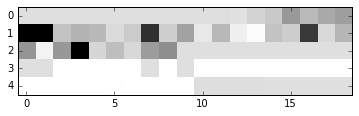

In [108]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(coef_l1_LR.reshape(5, 19)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)